# Goal:

Try training LGBM with basic features (14d prediction)

Group features:
- same id, product id, name first, name second, categores, warehouse, warhouse location, combos
- all of these --> lag sales, rolling sales, etc.

Date features:
- dow, month, year, etc.
- is holiday

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

In [2]:
DIRECTORY = './data/'
calendar = pd.read_csv(DIRECTORY + 'calendar.csv', parse_dates=['date'])
inventory = pd.read_csv(DIRECTORY + 'inventory.csv')
test = pd.read_csv(DIRECTORY + 'sales_test.csv', parse_dates=['date'])
train = pd.read_csv(DIRECTORY + 'sales_train.csv', parse_dates=['date'])
solution = pd.read_csv(DIRECTORY + 'solution.csv')
test_weights = pd.read_csv(DIRECTORY + 'test_weights.csv')

## Set Up Initial Df - no features

In [3]:
# Initial combined df
combined = pd.concat([train, test], axis=0)
combined = combined.merge(test_weights, on='unique_id', how='left') \
    .merge(inventory.drop(columns='warehouse'), on='unique_id', how='left') \
    .merge(calendar[['date', 'holiday_name', 'holiday', 'warehouse']], on=['date', 'warehouse'], how='left')
combined_no_holidays = combined[combined['holiday'] == 0].drop(columns=['holiday', 'holiday_name']).copy()
combined_no_holidays = combined_no_holidays.sort_values(by='date')
combined_no_holidays = combined_no_holidays.reset_index(drop=True)
del calendar, inventory, test, train, solution, test_weights, combined

In [4]:
features = combined_no_holidays

## Start to add features

In [5]:
# Add categorical features for groupings
def date_features(df):
    df = df.copy()
    df['day_of_year'] = df['date'].dt.day_of_year
    df['day_of_month'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

    yearly = CalendarFourier(freq='A', order=4).in_sample(df['date']).reset_index(drop=True)
    yearly.index = df.index
    monthly = CalendarFourier(freq='M', order=2).in_sample(df['date']).reset_index(drop=True)
    monthly.index = df.index
    df = pd.concat([df, yearly, monthly], axis=1)

    return df

features = date_features(features)

/Users/akhilkammila/miniconda3/envs/tradingClub/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
/Users/akhilkammila/miniconda3/envs/tradingClub/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


In [6]:
# Lag features
def add_shift_feature(df, groupby, shift_number):
    return df.groupby(groupby)['sales'].shift(shift_number).reset_index(level=0, drop=True)

def add_days_ago_feature(df, groupby, days_ago):
    date_shift_df = df[groupby + ['date', 'sales']].copy()
    date_shift_df['date'] = date_shift_df['date'] + pd.Timedelta(f'{days_ago}D')
    date_shift_df = date_shift_df.rename(columns={'sales': 'new_col'})

    df = df.merge(date_shift_df, on=groupby + ['date'], how='left')
    return df['new_col'].reset_index(level=0, drop=True)

groupings = [['unique_id'], ['name'], ['L1_category_name_en'], ['L2_category_name_en'],['L3_category_name_en'],['L4_category_name_en']]

shift_nums = [14, 16, 18, 21, 365]

for grouping in tqdm(groupings, desc='Groupings'):
    grouping_string = f'({'_'.join(grouping)})'
    for shift in shift_nums:
        features[f'{grouping_string}_shift_{shift}d'] = add_shift_feature(features, grouping, shift)
        features[f'{grouping_string}_days_ago_{shift}d'] = add_days_ago_feature(features, grouping, shift)

Groupings:  33%|███▎      | 2/6 [00:47<01:46, 26.59s/it]

: 

In [7]:
## Final Processing

def fix_df(df):
    # Change index to month
    df.index = df['date']
    df = df.sort_index()

    # Fix categoricals
    categorical = list(df.select_dtypes(include='object').columns)
    for col in categorical:
        df[col] = df[col].astype('category')

    # Rename features
    df.columns = df.columns.str.replace(r'["{}[\]:,\\]', '_', regex=True)

    # Drop availabilty
    if 'availability' in df.columns: df = df.drop(columns='availability')
    return df

final_df = fix_df(features)

In [8]:
final_df

,unique_id,date,warehouse,total_orders,sales,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,...,sin(2_freq=ME),cos(2_freq=ME),(unique_id)_shift_14d,(unique_id)_days_ago_14d,(unique_id)_shift_15d,(unique_id)_days_ago_15d,(unique_id)_shift_21d,(unique_id)_days_ago_21d,(unique_id)_shift_365d,(unique_id)_days_ago_365d
date,,,,,,,,,,,,,,,,,,,,,
2020-08-01,3841,2020-08-01,Prague_1,4111.0,40.58,37.69,0.00000,0.0,0.0,0.0,...,0.000000e+00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01,3303,2020-08-01,Brno_1,4797.0,35.62,23.72,0.00000,0.0,0.0,0.0,...,0.000000e+00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01,700,2020-08-01,Prague_1,4111.0,23.87,10.61,0.00000,0.0,0.0,0.0,...,0.000000e+00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01,830,2020-08-01,Prague_3,2466.0,14.27,11.40,0.00000,0.0,0.0,0.0,...,0.000000e+00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01,1841,2020-08-01,Prague_3,2416.0,13.33,32.63,0.00000,0.0,0.0,0.0,...,0.000000e+00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-16,4123,2024-06-16,Frankfurt_1,1189.0,NaN,2.31,0.00000,0.0,0.0,0.0,...,-2.449294e-16,1.0,12.16,12.16,8.51,8.51,9.87,12.61,59.13,17.89
2024-06-16,5040,2024-06-16,Prague_2,6073.0,NaN,38.13,0.00000,0.0,0.0,0.0,...,-2.449294e-16,1.0,10.16,10.16,6.05,6.05,15.31,15.31,20.21,6.30
2024-06-16,5188,2024-06-16,Frankfurt_1,1189.0,NaN,1.45,0.00000,0.0,0.0,0.0,...,-2.449294e-16,1.0,30.40,30.40,31.07,31.07,38.08,31.52,36.80,30.41


## Testing LGBM

In [9]:
# For below to work, index has to be months, 'date' should still be a col (removed later)
# No ( and , in column names
# final_df['date']

In [10]:
model = lgb.LGBMRegressor()

categorical = list(final_df.select_dtypes(include='category').columns)

train = final_df.loc[pd.to_datetime('2022-05-01'):pd.to_datetime('2024-05-19')]
val = final_df.loc[pd.to_datetime('2024-05-20'): pd.to_datetime('2024-06-02')]
test = final_df.loc[pd.to_datetime('2024-06-03'):]

train_data = lgb.Dataset(train.drop(columns=['sales', 'weight', 'date']), label=train['sales'], weight=train['weight'], categorical_feature=categorical)
val_data = lgb.Dataset(val.drop(columns=['sales', 'weight', 'date']), label=val['sales'], weight=val['weight'], categorical_feature=categorical)

params = {"objective": "regression", "metric": "mae"}
model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=3000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),  # Stops if no improvement in 50 rounds
        lgb.log_evaluation(period=100)  # Logs every 10 iterations
    ],

)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9315
[LightGBM] [Info] Number of data points in the train set: 2389900, number of used features: 41
[LightGBM] [Info] Start training from score 69.236419
Training until validation scores don't improve for 50 rounds
[100]	training's l1: 18.1793	valid_1's l1: 22.1034
[200]	training's l1: 17.0125	valid_1's l1: 21.1926
[300]	training's l1: 16.2997	valid_1's l1: 20.8094
[400]	training's l1: 15.7612	valid_1's l1: 20.4405
[500]	training's l1: 15.3625	valid_1's l1: 20.1347
[600]	training's l1: 15.0582	valid_1's l1: 1

In [11]:
train_preds = model.predict(train.drop(columns=['sales', 'weight', 'date']))
val_preds = model.predict(val.drop(columns=['sales', 'weight', 'date']))

In [12]:
train_error = mean_absolute_error(train['sales'].fillna(0), np.maximum(train_preds, 0), sample_weight=train['weight'])
val_error = mean_absolute_error(val['sales'].fillna(0), np.maximum(val_preds, 0), sample_weight=val['weight'])

print(f"Train MAE: {train_error:.4f}")
print(f"Val MAE: {val_error:.4f}")

Train MAE: 13.0076
Val MAE: 19.2362


In [13]:
# Test submission
test = final_df.loc[pd.to_datetime('2024-06-03'):]
submission_df = test.copy()

test_preds = model.predict(test.drop(columns=['sales', 'weight', 'date']))
submission_df.loc[:,'sales_hat'] = np.maximum(test_preds, 0)

In [14]:
submission_df['id'] = submission_df['unique_id'].astype(str).str.cat(submission_df['date'].astype(str), sep='_')
submission_df[['id', 'sales_hat']].to_csv('submission.csv', index=False)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

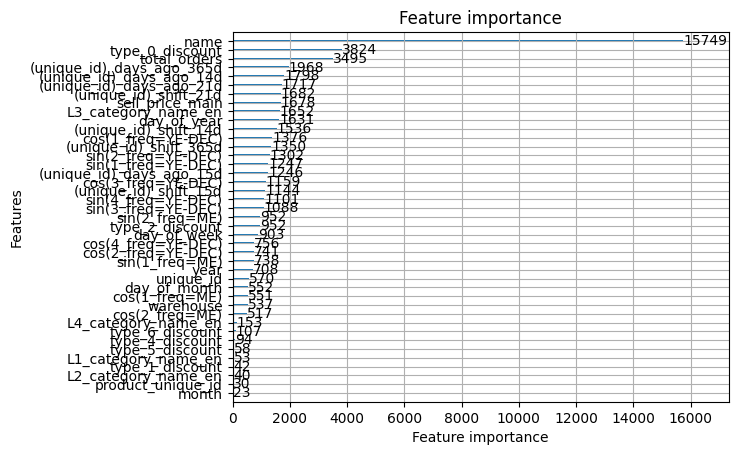

In [15]:
lgb.plot_importance(model)

## What is contributing to the error?

What do my predictions look like; am I even in the right range?

In [207]:
train.loc[:,'predictions'] = train_preds
val.loc[:,'predictions'] = val_preds
test.loc[:,'predictions'] = test_preds

/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_51039/1626768766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:,'predictions'] = train_preds
/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_51039/1626768766.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val.loc[:,'predictions'] = val_preds
/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_51039/1626768766.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [208]:
test_weights = pd.read_csv(DIRECTORY + 'test_weights.csv')
weight_avg = test_weights['weight'].mean()
for df in [train, val, test]:
    weight_div = train['weight'].mean()
    df.loc[:,'residuals'] = np.abs(df['predictions'] - df['sales']) * df['weight']/weight_div

/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_51039/2415572750.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'residuals'] = np.abs(df['predictions'] - df['sales']) * df['weight']/weight_div
/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_51039/2415572750.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'residuals'] = np.abs(df['predictions'] - df['sales']) * df['weight']/weight_div
/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_51039/2415572750.

<Axes: xlabel='sales', ylabel='predictions'>

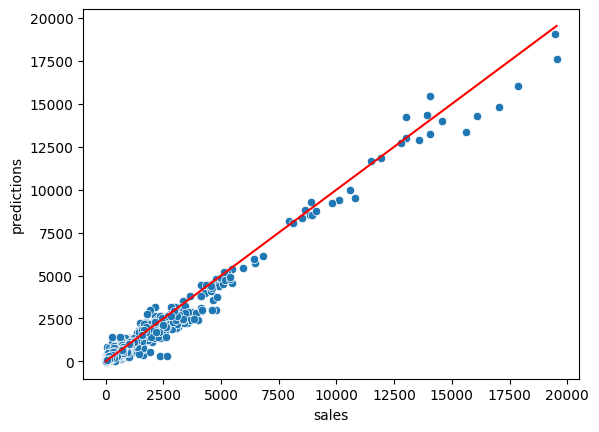

In [209]:
sns.scatterplot(x=val['sales'], y=val['predictions'])

sales_range = np.arange(0, np.max(val['sales']))
sns.lineplot(x=sales_range, y=sales_range, color='red')

In [210]:
val.nlargest(5, 'residuals')[['unique_id', 'sales', 'predictions', 'residuals']]

,unique_id,sales,predictions,residuals
date,,,,
2024-05-22,620,2371.64,328.425453,3675.908872
2024-05-28,620,264.05,1422.554593,2084.243830
2024-06-02,5322,226.88,668.630582,1951.822382
2024-05-29,2635,54.23,456.605593,1922.298886
2024-05-27,620,2351.36,1362.191680,1779.594125


In [211]:
train.nlargest(5, 'residuals')[['unique_id', 'sales', 'predictions', 'residuals']]

,unique_id,sales,predictions,residuals
date,,,,
2023-06-12,2463,1920.88,688.977569,1707.213712
2024-02-03,2708,285.95,16.673193,1563.506078
2023-05-24,5428,615.63,26.352161,1392.226943
2023-01-10,3398,1007.54,714.938043,1388.442258
2023-02-15,4117,1448.56,409.805819,1309.462972


<Axes: xlabel='date', ylabel='sales'>

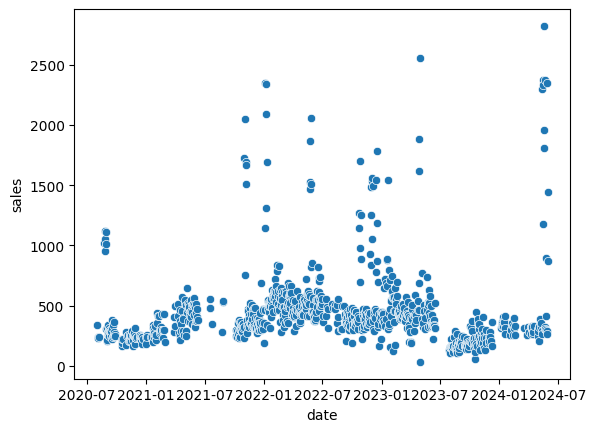

In [213]:
sns.scatterplot(data=final_df[final_df['unique_id'] == 620], x='date', y='sales')

Random sample graphs from val set

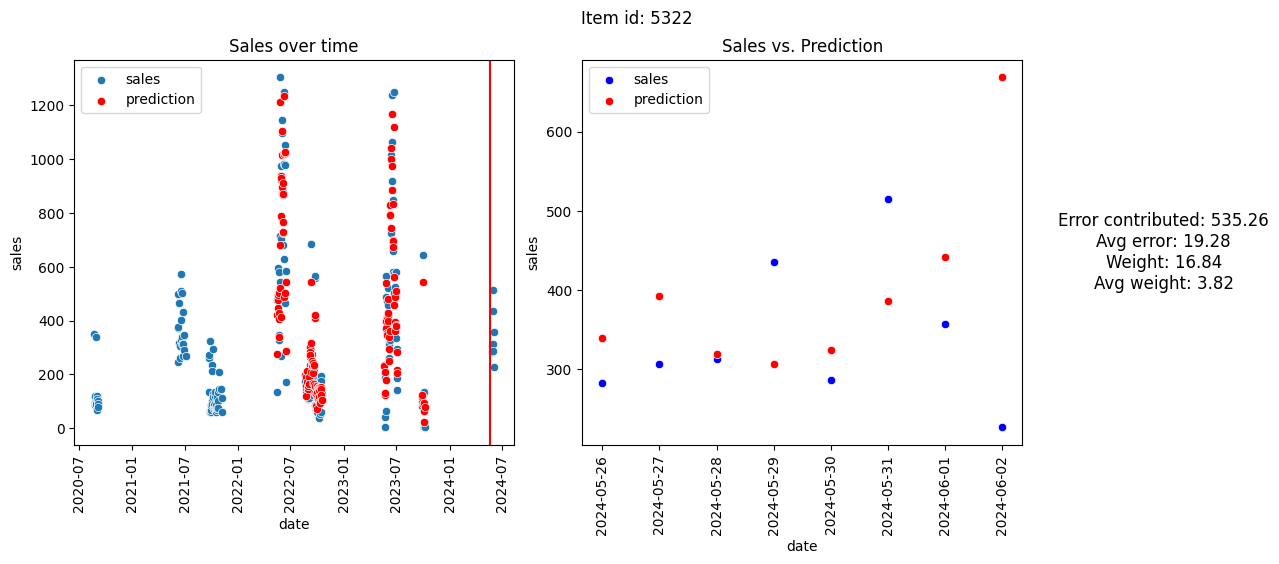

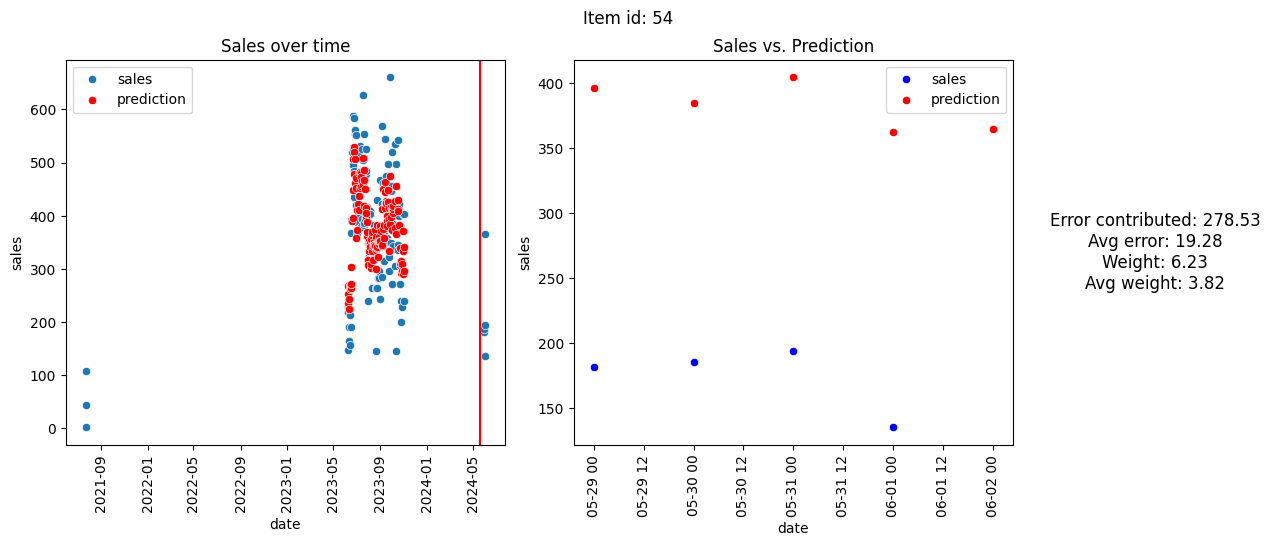

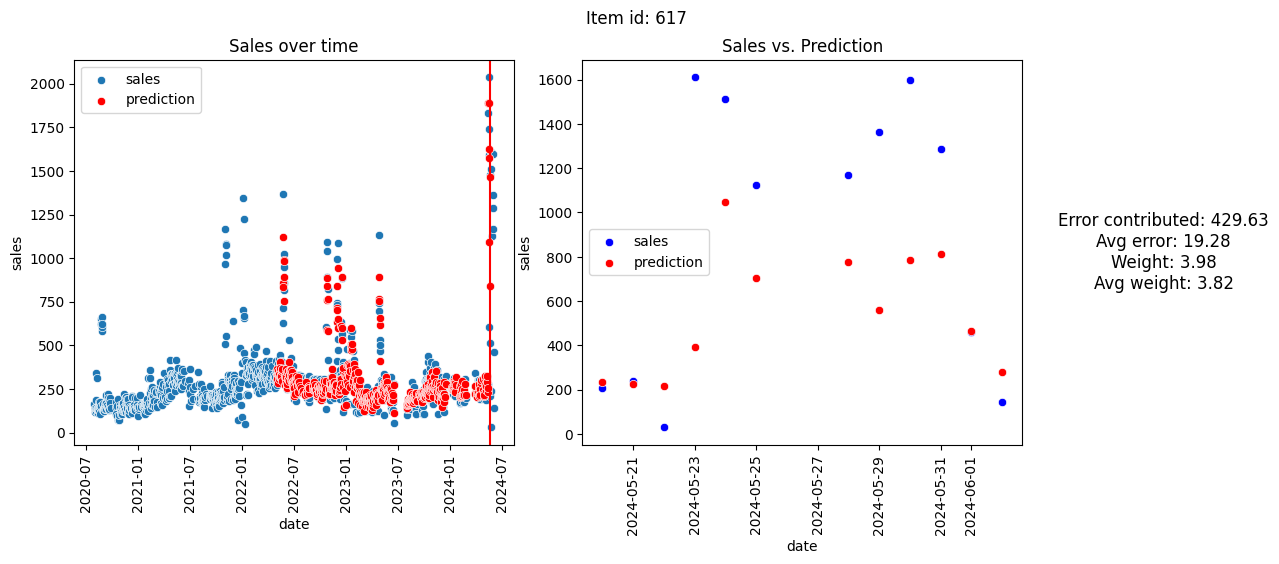

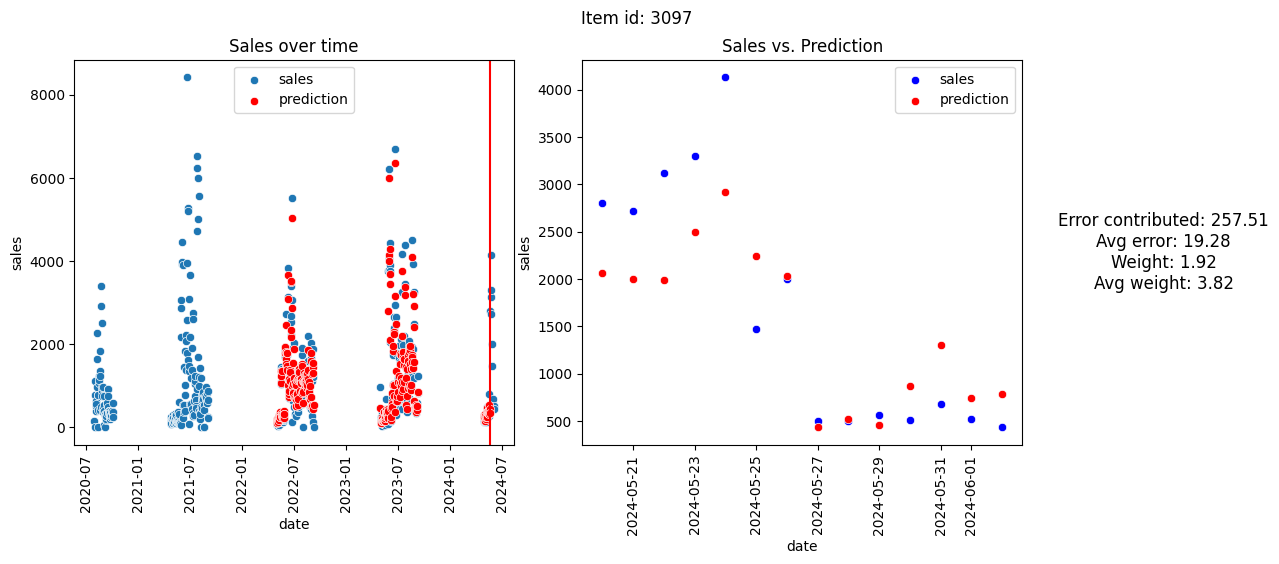

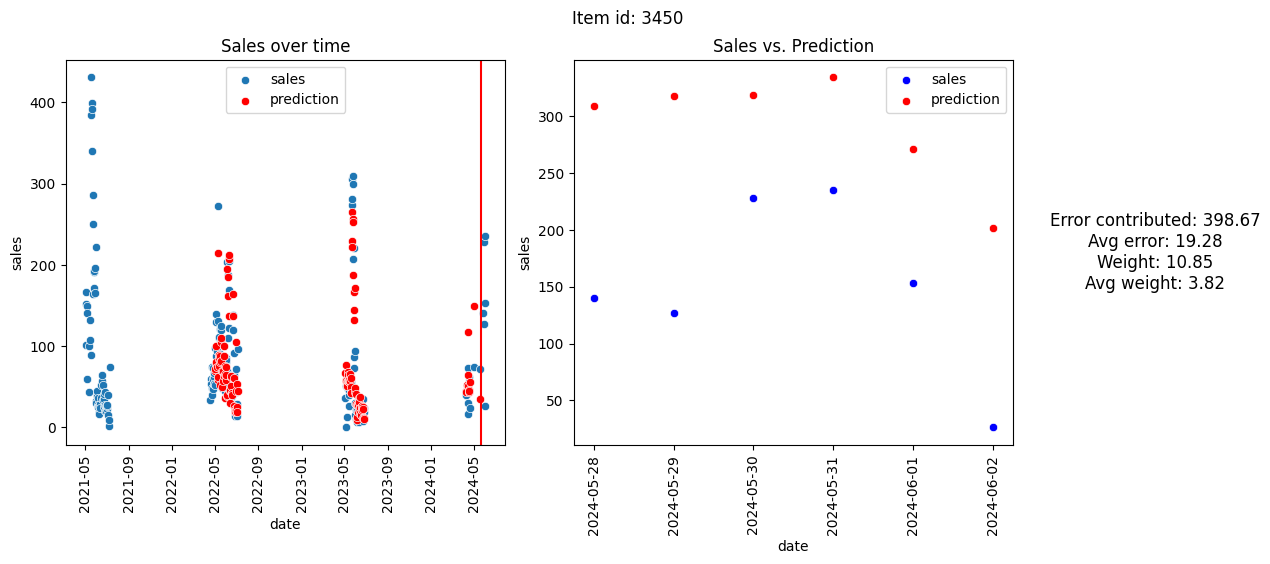

In [236]:
for i in range(5):
    relevant_items = val.groupby(['unique_id'])['residuals'].mean().sort_values(ascending=False).head(30).index
    chosen_id = np.random.choice(relevant_items)
    filtered_val = val[val['unique_id'] == chosen_id]
    fig, axs = plt.subplots(1, 3, figsize=(15,5), gridspec_kw={'width_ratios': [3, 3, 1]})
    axs = axs.flatten()

    sns.scatterplot(data=final_df[final_df['unique_id'] == chosen_id], x='date', y='sales', ax=axs[0], label='sales')
    sns.scatterplot(data=train[train['unique_id'] == chosen_id], x='date', y='predictions', ax=axs[0], color='red', label='prediction')
    plt.sca(axs[0])
    plt.xticks(rotation=90)
    plt.title('Sales over time')
    plt.axvline(x=pd.to_datetime('2024-05-20'), color='red')

    sns.scatterplot(data=filtered_val, x='date', y='sales', ax=axs[1], color='blue', label='sales')
    sns.scatterplot(data=filtered_val, x='date', y='predictions', ax=axs[1], color='red', label='prediction')
    plt.sca(axs[1])
    plt.xticks(rotation=90)
    plt.title('Sales vs. Prediction')

    textstr = (
        f"Error contributed: {filtered_val['residuals'].mean():.2f}\n"
        f"Avg error: {val['residuals'].mean():.2f}\n"
        f"Weight: {filtered_val['weight'].iloc[0]:.2f}\n"
        f"Avg weight: {val['weight'].mean():.2f}"
    )
    axs[2].text(
        0.5, 0.5, textstr,
        transform=axs[2].transAxes,
        fontsize=12,
        verticalalignment='center',
        horizontalalignment='center'
    )
    axs[2].axis('off')
    plt.suptitle(f'Item id: {chosen_id}');
    plt.show()

# print("Error contributed:", filtered_val['residuals'].mean())
# print("Avg error:", val['residuals'].mean())
# print("Weight:", filtered_val['weight'].iloc[0])
# print("Avg weight:", val['weight'].mean())


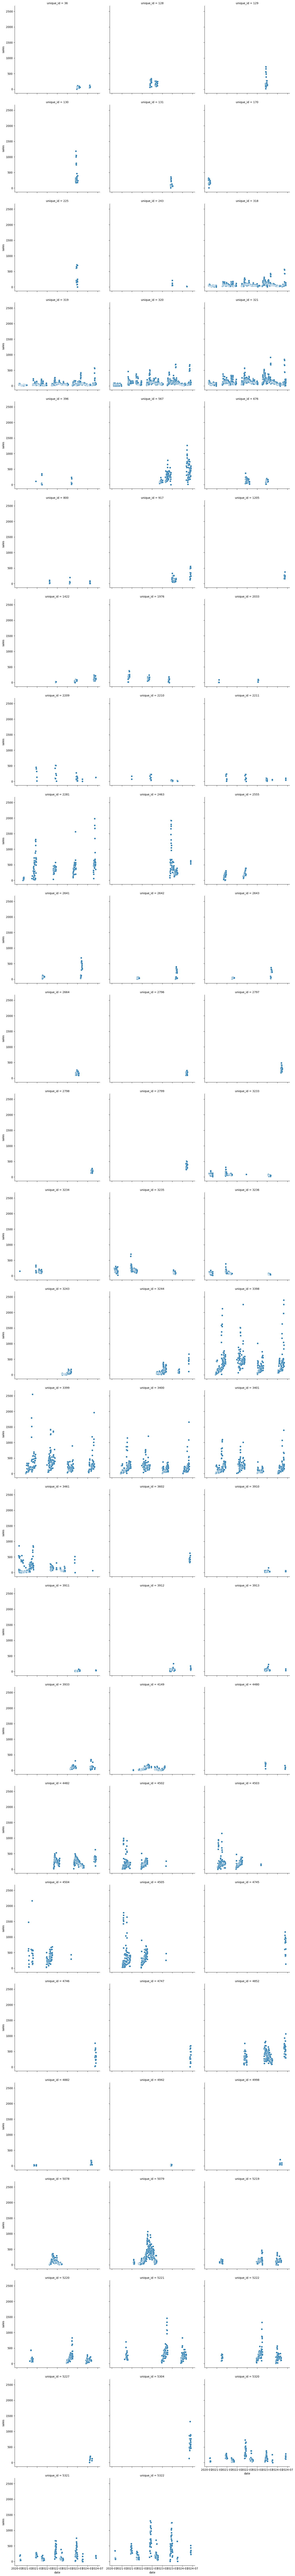

In [223]:
# 917
features['name_first'] = features['name'].str.split('_').str[0]
sns.relplot(features[features['name_first'] == 'Strawberry'], x='date', y='sales', col='unique_id', col_wrap=3)

In [ ]:
# 917
sns.relplot(features[features['name_first'] == 'Strawberry'].groupby('date')['sales'].sum(), x='date', y='sales', col='unique_id', col_wrap=3)

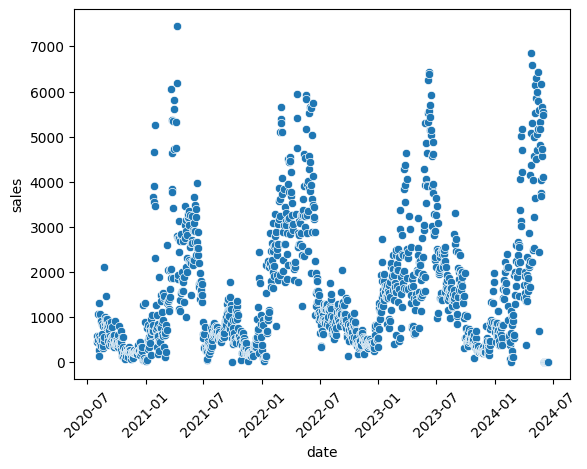

In [ ]:
sns.scatterplot(data=features[features['name_first'] == 'Strawberry'][['sales']].groupby(['date'])[['sales']].sum(), \
                x='date', y='sales')
plt.xticks(rotation=45);